<a href="https://colab.research.google.com/github/Kravty/MachineLearning/blob/main/PyTorch_CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3> CNN model in PyTorch used for classification of CIFAR10 dataset (with data augumentation).
<h3> Multiple convolutional layers are used (VGG alike) in order to obtain better accuracy.


<h3> Import of libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix
import itertools

<h3> Data preparation 

In [2]:
# Data augmentation - manipulating training data to get more input data for the model
transformer_train = torchvision.transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  torchvision.transforms.RandomHorizontalFlip(p=0.5),
  torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
  transforms.ToTensor(), 
])

train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transformer_train,
    download=True)
test_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [3]:
print(f"Type of the train dataset data: {type(train_dataset.data)}\n")
print(f"Shape of the train dataset data: {train_dataset.data.shape}")

Type of the train dataset data: <class 'numpy.ndarray'>

Shape of the train dataset data: (50000, 32, 32, 3)


In [4]:
print(f"Type of the train dataset targets: {type(train_dataset.targets)}\n")
K = len(set(train_dataset.targets))
print(f"Number of classes: {K}")

Type of the train dataset targets: <class 'list'>

Number of classes: 10


In [5]:
# Label mapping
labels = '''Airplane
Automobile
Bird
Cat
Deer
Dog
Frog
Horse
Ship
Truck'''.split("\n")

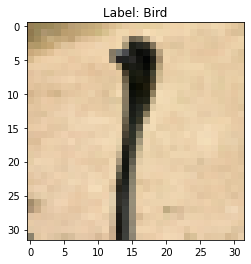

In [6]:
index = np.random.randint(50000)
plt.imshow(train_dataset.data[index])
plt.title(f'Label: {labels[train_dataset.targets[index]]}')
plt.show();

<H3> Buidling the model

In [7]:
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()

    # Convolutional layers
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2)
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2)
    )
    
    # Dense layers
    self.d1 = nn.Linear(128 * 4 * 4, 1024)
    self.d2 = nn.Linear(1024, K)
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1)
    x = F.dropout(x, p=0.5)
    x = F.relu(self.d1(x))
    x = F.dropout(x, p=0.2)
    x = self.d2(x)
    return x

In [8]:
# Instantiate the model
model = CNN(K)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [11]:
# Data loader - it generates batches in the training loop and shuffle
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

<h3> Training the model

In [12]:
# Training loop function
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    # Variable for storing train losses
    train_loss = []
    
    for inputs, targets in train_loader:
      # Moving the data to GPU
      inputs, targets = inputs.to(device), targets.to(device)
      
      # Zero the gradients accumulated by PyTorch
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      # Appending the loss to list of losses per iteration/batch
      train_loss.append(loss.item())

    # Taking mean value of previous losses as loss per epoch
    train_loss = np.mean(train_loss)
    
    model.eval()
    

    # Variable for storing test losses
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    
    test_loss = np.mean(test_loss)

    # Saving the losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    # Calculating learning time per epoch
    dt = datetime.now() - t0
    
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f},  Duration: {dt}')
  
  return train_losses, test_losses

In [13]:
# Calling training function
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=60)

Epoch 1/60, Train Loss: 1.4341,       Test Loss: 1.0648,  Duration: 0:00:25.681040
Epoch 2/60, Train Loss: 0.9968,       Test Loss: 0.8455,  Duration: 0:00:26.293625
Epoch 3/60, Train Loss: 0.8430,       Test Loss: 0.8788,  Duration: 0:00:26.211133
Epoch 4/60, Train Loss: 0.7431,       Test Loss: 0.8753,  Duration: 0:00:26.258520
Epoch 5/60, Train Loss: 0.6900,       Test Loss: 0.6730,  Duration: 0:00:25.739295
Epoch 6/60, Train Loss: 0.6441,       Test Loss: 0.6646,  Duration: 0:00:26.678114
Epoch 7/60, Train Loss: 0.6119,       Test Loss: 0.6137,  Duration: 0:00:26.558682
Epoch 8/60, Train Loss: 0.5804,       Test Loss: 0.5785,  Duration: 0:00:25.450830
Epoch 9/60, Train Loss: 0.5519,       Test Loss: 0.8091,  Duration: 0:00:25.602518
Epoch 10/60, Train Loss: 0.5376,       Test Loss: 0.6108,  Duration: 0:00:25.860980
Epoch 11/60, Train Loss: 0.5196,       Test Loss: 0.5647,  Duration: 0:00:25.694038
Epoch 12/60, Train Loss: 0.5002,       Test Loss: 0.5598,  Duration: 0:00:26.504122
E

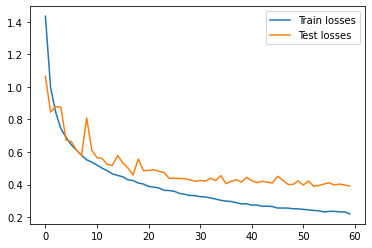

In [14]:
plt.plot(train_losses, label='Train losses')
plt.plot(test_losses, label='Test losses')
plt.legend()
plt.show();

In [15]:
# Calculating accuracy
model.eval()

# Variables for counting train accuracy
n_correct = 0
n_total = 0

for inputs, targets in train_loader:
  # Moving data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # Updating the counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


# Zero the variables for counting test accuracy
n_correct = 0
n_total = 0

# Same loop for test data
for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)
  
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9265, Test acc: 0.8807


In [16]:
# Confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization


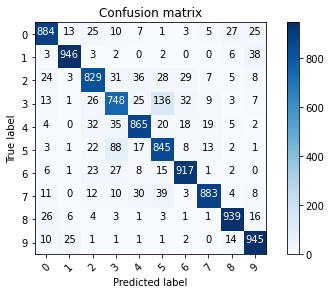

In [17]:
# Getting all predictions in an array and plotting confusion matrix
x_test = test_dataset.data
y_test = np.array(test_dataset.targets)
p_test = np.array([])

for inputs, targets in test_loader:
  # Moving data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Getting prediction
  _, predictions = torch.max(outputs, 1)
  
  # Updating p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

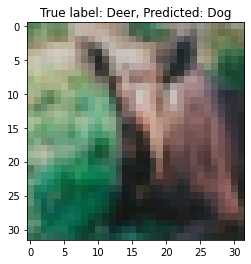

In [19]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(32, 32, 3))
plt.title(f"True label: {labels[y_test[i]]}, Predicted: {labels[p_test[i]]}");